# Testing the FAR vs Rent Stabilization Data  - > REVIEW 2
Using prepared data to compare change over time from 07 to 22.

## Import and Prepare Data

In [17]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

pd.set_option('display.max_columns', None)

path = r"C:\Users\cansu\Downloads\Analysis_2022_4Summary_Zoning.xls"
df = pd.read_excel( path )

df = df.drop(columns = ['ucbbl','pdfsoa2022','histdist','landmark','availfar','availarea2','YearBuilt_24','UnitsRes_24','UnitsRes_07','BuiltFAR_07'])

df.columns = [i.split("_")[1] if i.startswith("_") else i for i in df.columns ]
df.columns = [i.split("uc")[1]+'uc' if i.startswith("uc") else i for i in df.columns ]

df = df.dropna( subset=['BBL_24','BBL_07'], how = 'all' ).copy()
df['BBL_07'] = df['BBL_07'].astype(str)
df['BBL_24'] = df['BBL_24'].astype(str)

df['BBL_07'] = df['BBL_07'].str.split('.').str[0]
df['BBL_24'] = df['BBL_24'].str.split('.').str[0]

dfs = df[['BBL_07','BBL_24','2007uc','2022uc','cd','ZD_Change']].copy()
dfs['cd'] = dfs['cd'].astype(str)
dfs['cd'] = dfs['cd'].str.split('.').str[0]

df.head()

,2007uc,2008uc,2009uc,2010uc,2011uc,2012uc,2013uc,2014uc,2015uc,2016uc,2017uc,2018uc,2019uc,2020uc,2021uc,2022uc,change,cd,address,BBL_24,BBL_07,ZoneDist07,ZoneDist24,ZD_Change
0,6179,5889,5467,5680,8635,8634,8635,8647,8655,8659,8659,8764,8764,8764,8764,8770,2591,106,240 1 AVENUE,1009720001,1009720001,R7-2,R7-2,n
1,1749,1641,1506,1579,2479,2479,2480,2482,2482,2482,2482,2480,2480,2478,2477,2480,731,106,342 1 AVENUE,1009780001,1009780001,R7-2,R7-2,n
2,0,0,0,607,156,276,1276,1276,1276,1276,1276,1276,1276,1276,1276,1212,1212,104,533 11 AVENUE,1010897502,1010890003,C6-4,C6-4,n
3,0,0,0,0,7,0,921,921,921,921,921,921,921,918,921,921,921,104,1 RIVER PLACE,1010890001,1010890001,C6-4,C6-4,n
4,0,0,0,0,0,560,898,899,899,902,901,900,899,899,899,899,899,101,8 SPRUCE STREET,1001007502,1001000001,C6-4,C6-4,n


In [18]:
df= df[~df['ZoneDist24'].str.startswith('M')]

### Import Pluto 07

In [19]:
filterValues = dfs['BBL_07'].dropna().values
filterValues = [i for i in filterValues if i != 'nan' ]
filterValues = "','".join( filterValues)

In [20]:
folder = r'C:\Users\cansu\Downloads\nyc_pluto_07c'
files = os.listdir( folder )
files = [ os.path.join(folder,i) for i in files if i.endswith('.TXT')]

data07 = duckdb.sql(
    f"""
    SELECT UnitsRes, ResArea, BldgArea, BuiltFAR, MaxAllwFAR, BBL::STRING as BBL, Landmark, histdist, ZoneDist1, XCOORD, YCOORD
    FROM read_csv( {files}, ignore_errors=True , types=[INT, FLOAT, FLOAT, STRING, STRING, STRING, STRING,FLOAT, FLOAT] )
    WHERE BBL IN ('{ filterValues }')
    """
    ).df()

data07.columns = [f"{i}_07" for i in data07.columns.str.lower()]

data07['landmark_07'] = data07['landmark_07'].str.strip()
data07['landmark_07'] = np.where( data07['landmark_07'] == '', False, True )

data07['histdist_07'] = data07['histdist_07'].str.strip()
data07['histdist_07'] = np.where( data07['histdist_07'] == '', None, data07['histdist_07'] )

data07 = data07.astype({
        'maxallwfar_07': float,
        'unitsres_07': float,
        'builtfar_07': float,
        'resarea_07': float,
        'bldgarea_07': float
    })
 
data07['maxallwfar_07'] = np.where( data07['maxallwfar_07'] == 10, 12, data07['maxallwfar_07'] )

data07['availfar_07'] = data07['maxallwfar_07'] - data07['builtfar_07']
data07['availfar_perc_07'] = data07['availfar_07'] / data07['maxallwfar_07']

data07.head(3)


,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,bbl_07,landmark_07,histdist_07,zonedist1_07,xcoord_07,ycoord_07,availfar_07,availfar_perc_07
0,42.0,32843.0,44097.0,1.45,15.0,1000077501,False,Fraunces Tavern Block,C5-5,0981258,0195549,13.55,0.903333
1,0.0,0.0,154035.0,17.01,15.0,1000080032,False,None,C5-5,0980719,0195354,-2.01,-0.134000
2,293.0,335746.0,335746.0,24.93,15.0,1000150022,True,None,C5-5,0979934,0196624,-9.93,-0.662000


### Pluto 22

In [21]:
filterValues = dfs['BBL_24'].dropna().values
filterValues = [i for i in filterValues if i != 'nan' ]
filterValues = "','".join( filterValues)
filterValues

data22 = duckdb.sql(
    f"""
    SELECT address, yearbuilt, unitsres, resarea, bldgarea, builtfar, residfar, bbl::STRING as bbl, histdist, xcoord, ycoord
    FROM read_csv( "C:/Users/cansu/Downloads/nyc_pluto_22v1_arc_csv/pluto_22v1.csv" , ignore_errors=True , types=[STRING,INT,INT,INT,INT,INT,FLOAT,STRING, STRING,FLOAT,FLOAT] )
    WHERE BBL IN ('{ filterValues }' )
    """
    ).df()

data22['bbl'] = data22['bbl'].str.split('.').str[0]
data22['MaxAllwFAR'] = data22['residfar'] 
data22.columns = [f"{i}_22" for i in data22.columns.str.lower()]

# Add Allowances
data22['maxallwfar_22'] = np.where( data22['maxallwfar_22'] == 10, 12, data22['maxallwfar_22'] )

data22['availfar_22'] = data22['maxallwfar_22'] - data22['builtfar_22']
data22['availfar_perc_22'] = data22['availfar_22'] / data22['maxallwfar_22']

data22.head(3)

,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,bbl_22,histdist_22,xcoord_22,ycoord_22,maxallwfar_22,availfar_22,availfar_perc_22
0,17 WEST 74 STREET,1954,20.0,12580.0,12580,3.12,4.0,1011270022,Upper West Side / Central Park West Historic D...,990943.0,222773.0,4.0,0.88,0.2200
1,1621 2 AVENUE,1920,6.0,4725.0,6300,3.09,10.0,1015300022,None,997304.0,222306.0,12.0,8.91,0.7425
2,1623 2 AVENUE,1920,6.0,4725.0,6300,3.09,10.0,1015300023,None,997316.0,222328.0,12.0,8.91,0.7425


### Join Data and Filter Comparisons

In [22]:
dfj = dfs.join( data07.set_index('bbl_07'), on='BBL_07', how='left' ).join( data22.set_index('bbl_22'), on='BBL_24', how='left' )
print( dfj.shape[0] , "<>", dfs.shape[0] )
dfj.head(3)

15343 <> 15343


,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,histdist_07,zonedist1_07,xcoord_07,ycoord_07,availfar_07,availfar_perc_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,histdist_22,xcoord_22,ycoord_22,maxallwfar_22,availfar_22,availfar_perc_22
0,1009720001,1009720001,6179,8770,106,n,8756.0,8367942.0,8942176.0,3.34,3.44,False,None,R7-2,0990379,0205835,0.10,0.029070,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,3.44,None,990376.0,205864.0,3.44,0.10,0.029070
1,1009780001,1009780001,1749,2480,106,n,2491.0,3102556.0,3122165.0,3.77,3.44,False,None,R7-2,0990626,0206995,-0.33,-0.095930,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,3.44,None,990629.0,207012.0,3.44,-0.33,-0.095930
2,1010890003,1010897502,0,1212,104,n,1266.0,854683.0,854683.0,21.97,12.00,False,None,C6-4,0984487,0216424,-9.97,-0.830833,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.00,None,984462.0,216453.0,12.00,-7.16,-0.596667


In [23]:
print( dfj.shape[0])

15343


### Change Variables

In [24]:
dfj['change_uc'] = dfj['2022uc'] - dfj['2007uc']
dfj['change_availfar'] = dfj['builtfar_22'] - dfj['builtfar_07']
dfj['change_availfar_perc'] = dfj['availfar_perc_22'] - dfj['availfar_perc_07']

dfj['xcoord'] = dfj['xcoord_22'].combine_first( dfj['xcoord_07'] )
dfj['ycoord'] = dfj['ycoord_22'].combine_first( dfj['ycoord_07'] )
dfj = dfj[ dfj['xcoord'] != '       ' ].copy()
dfj = dfj.dropna( subset=['xcoord','ycoord'] )

dfj = dfj.drop( columns=['xcoord_07','ycoord_07','xcoord_22','ycoord_22'] )

dfj.head(3)

,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,histdist_07,zonedist1_07,availfar_07,availfar_perc_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,histdist_22,maxallwfar_22,availfar_22,availfar_perc_22,change_uc,change_availfar,change_availfar_perc,xcoord,ycoord
0,1009720001,1009720001,6179,8770,106,n,8756.0,8367942.0,8942176.0,3.34,3.44,False,None,R7-2,0.10,0.029070,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,3.44,None,3.44,0.10,0.029070,2591,0.00,0.000000,990376.0,205864.0
1,1009780001,1009780001,1749,2480,106,n,2491.0,3102556.0,3122165.0,3.77,3.44,False,None,R7-2,-0.33,-0.095930,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,3.44,None,3.44,-0.33,-0.095930,731,0.00,0.000000,990629.0,207012.0
2,1010890003,1010897502,0,1212,104,n,1266.0,854683.0,854683.0,21.97,12.00,False,None,C6-4,-9.97,-0.830833,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.00,None,12.00,-7.16,-0.596667,1212,-2.81,0.234167,984462.0,216453.0


In [25]:
dfj.loc[dfj['change_uc'] > 0, 'change_uc_cat'] = 'Increase'
dfj.loc[dfj['change_uc'] == 0, 'change_uc_cat'] = 'Unchanged'
dfj.loc[dfj['change_uc'] < 0, 'change_uc_cat'] = 'Decrease'
dfj.loc[dfj['change_uc'] == dfj['2007uc'], 'change_uc_cat'] = 'Loss'

dfj['change_uc_cat'].value_counts()

change_uc_cat
Decrease     10309
Unchanged     2335
Increase      1976
Loss           722
Name: count, dtype: int64

In [26]:
dfj.shape[0]

15342

### Hist Dists

In [27]:
geo_dfj = gpd.GeoDataFrame( dfj, geometry=gpd.points_from_xy( dfj['xcoord'], dfj['ycoord'] ) , crs=2263 )
geo_dfj.head()

,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,histdist_07,zonedist1_07,availfar_07,availfar_perc_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,histdist_22,maxallwfar_22,availfar_22,availfar_perc_22,change_uc,change_availfar,change_availfar_perc,xcoord,ycoord,change_uc_cat,geometry
0,1009720001,1009720001,6179,8770,106,n,8756.0,8367942.0,8942176.0,3.34,3.44,False,None,R7-2,0.10,0.029070,240 1 AVENUE,1945.0,8764.0,8367942.0,8942176.0,3.34,3.44,None,3.44,0.10,0.029070,2591,0.00,0.000000,990376.0,205864.0,Increase,POINT (990376.000 205864.000)
1,1009780001,1009780001,1749,2480,106,n,2491.0,3102556.0,3122165.0,3.77,3.44,False,None,R7-2,-0.33,-0.095930,342 1 AVENUE,1947.0,2491.0,3102556.0,3122165.0,3.77,3.44,None,3.44,-0.33,-0.095930,731,0.00,0.000000,990629.0,207012.0,Increase,POINT (990629.000 207012.000)
2,1010890003,1010897502,0,1212,104,n,1266.0,854683.0,854683.0,21.97,12.00,False,None,C6-4,-9.97,-0.830833,533 11 AVENUE,2005.0,1276.0,895990.0,954682.0,19.16,10.00,None,12.00,-7.16,-0.596667,1212,-2.81,0.234167,984462.0,216453.0,Increase,POINT (984462.000 216453.000)
3,1010890001,1010890001,0,921,104,n,921.0,788774.0,887879.0,8.07,12.00,False,None,C6-4,3.93,0.327500,1 RIVER PLACE,1999.0,921.0,788774.0,887879.0,8.79,10.00,None,12.00,3.21,0.267500,921,0.72,-0.060000,984121.0,216628.0,Increase,POINT (984121.000 216628.000)
4,1001000001,1001007502,0,899,101,n,0.0,0.0,301941.0,4.82,12.00,False,None,C6-4,7.18,0.598333,8 SPRUCE STREET,2007.0,899.0,773169.0,900766.0,21.77,10.00,None,12.00,-9.77,-0.814167,899,16.95,-1.412500,982676.0,198302.0,Increase,POINT (982676.000 198302.000)


#### Hist dist

In [31]:
histdist = r"C:\Git_Repo\RentStabilization\DATA\HistoricDistricts_After2007\HistoricDistricts_After2007.shp"
histdist = gpd.read_file( histdist )
histdist.head(2)

,BOROUGH,LP_NUMBER,CURRENT_,AREA_NAME,EXTENSION,STATUS_OF_,LAST_ACTIO,BOUNDARY_N,PUBLIC_HEA,OTHER_HEAR,Shape_area,Shape_len,DESDATE,CALDATE,DATE,geometry
0,BK,LP-02567,Yes,Chester Court Historic District,No,DESIGNATED,DESIGNATED,AS IDENTIFIED BY RESEARCH DEPARTMENT (AND DETE...,11/25/2014,None,38403.070666,803.900855,12/16/2014,10/28/2014,2014-12-16,"POLYGON ((995061.231 179254.343, 995072.649 17..."
1,QN,LP-02319,Yes,Ridgewood North Historic District,No,DESIGNATED,DESIGNATED,None,12/16/2008,None,353621.787043,2628.766260,9/15/2009,10/28/2008,2009-09-15,"POLYGON ((1010677.070 197052.713, 1010595.846 ..."


In [33]:
geo_dfj = gpd.sjoin( geo_dfj, histdist, how='left', op='intersects' )
geo_dfj = geo_dfj[ geo_dfj['AREA_NAME'].isnull() ]
print( geo_dfj.shape[0] )

14277


c:\Users\cansu\.conda\envs\rent-data\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [37]:
geo_dfj = geo_dfj[geo_dfj['cd'].astype(int) < 112 ]
print( geo_dfj.shape[0] )

12701


#### Rezone

In [38]:
rezones = r'C:\Git_Repo\RentStabilization\DATA\ZoningDistrictsChanged_After2007\ZoningDistrictsChanged_After2007.shp'
rezones = gpd.read_file( rezones )
rezones.head(2)

,EFFECTIVE,STATUS,ULURPNO,LUCATS,PROJECT_NA,Shape_Leng,Shape_Area,geometry
0,2009-10-14,Adopted,060551zmq,060551,BRIARWOOD PLAZA,735.793336,29679.878050,"POLYGON ((1047145.436 218921.709, 1047385.979 ..."
1,2009-10-28,Adopted,060419zmq,060419,SOUTH CONDUIT REZONING,820.472092,38034.872597,"POLYGON ((1054113.758 181832.999, 1054297.918 ..."


In [43]:
if "index_right" in geo_dfj.columns: geo_dfj = geo_dfj.drop(columns=['index_right'])
geo_dfj = gpd.sjoin( geo_dfj, rezones, how='left', predicate='intersects' )
geo_dfj = geo_dfj[ geo_dfj['PROJECT_NA'].isnull() ]
print( geo_dfj.shape[0] )

9679


## Compare

In [44]:
geo_dfj['change_uc_perc'] = geo_dfj['change_uc'] / geo_dfj['2007uc']
geo_dfj['change_uc_perc'] = np.where( geo_dfj['change_uc_perc'] == np.inf, 1, geo_dfj['change_uc_perc'] )

geo_dfj[['change_uc','2007uc','2022uc','change_uc_perc']]

,change_uc,2007uc,2022uc,change_uc_perc
0,2591,6179,8770,0.419324
1,731,1749,2480,0.417953
2,1212,0,1212,1.000000
3,921,0,921,1.000000
4,899,0,899,1.000000
...,...,...,...,...
15336,0,0,0,NaN
15337,0,0,0,NaN
15339,0,0,0,NaN
15340,0,0,0,NaN


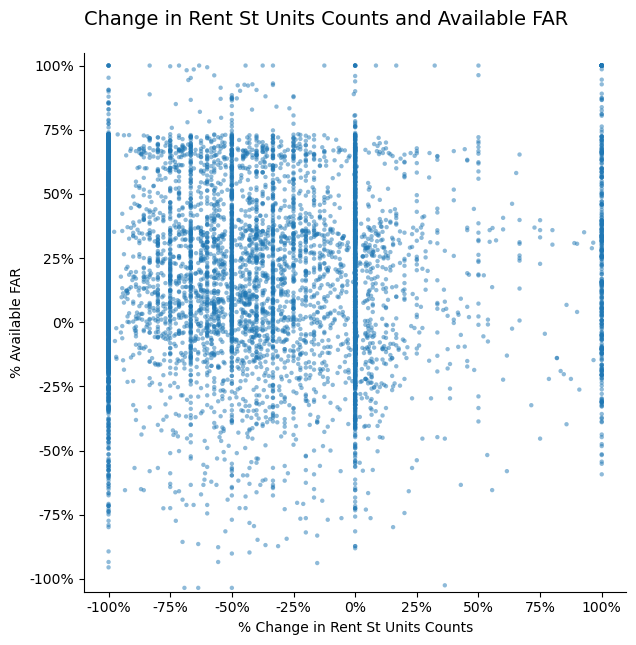

In [45]:
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(
    data = geo_dfj[
        (geo_dfj['availfar_07'].between( geo_dfj['availfar_07'].quantile(0.05) , geo_dfj['availfar_07'].quantile(0.95))) &
        (geo_dfj['change_uc_perc'].between( geo_dfj['change_uc_perc'].quantile(0.025), geo_dfj['change_uc_perc'].quantile(0.975) ))
        ],
    x = 'change_uc_perc',
    y = 'availfar_perc_07',
    s = 10, ec='none', alpha=0.5
)

ax.set_ylim( -1.05,1.05 )

sns.despine()
ax.set_title( "Change in Rent St Units Counts and Available FAR" , loc='left' , fontsize=14 , pad= 20)
ax.set_xlabel( "% Change in Rent St Units Counts" )
ax.set_ylabel( "% Available FAR" )

ax.set_xticks( np.arange(-1,1.1,0.25) , labels=[f"{i:.0%}" for i in np.arange(-1,1.1,0.25)] )
ax.set_yticks( np.arange(-1,1.1,0.25) , labels=[f"{i:.0%}" for i in np.arange(-1,1.1,0.25)] );

## Filter Data

## counts

In [46]:
geo_dfj = geo_dfj[ geo_dfj['change_uc'] <= 0 ]
print( geo_dfj.shape[0] ) 

8558


In [48]:
geo_dfj = geo_dfj[ ~(geo_dfj['yearbuilt_22'] >= 2007) ]
print( geo_dfj.shape[0] )

8455


In [43]:
geo_dfj = geo_dfj[
    (geo_dfj['ZD_Change'] == 'n') &
    (geo_dfj['cd'].astype(int) < 112) &
    (geo_dfj['change_uc'] <= 0) &
    ~(geo_dfj['yearbuilt_22'] >= 2007)
]

print( geo_dfj.shape[0] )

6988


In [51]:
cats = [ 0.2 ,0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 ]
for c in cats:
    geo_dfj[ f'availfar_perc_morethan_{c*100:.0f}'] = np.where( geo_dfj['availfar_perc_07'] > c, True, False )

geo_dfj.head(3)

,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,histdist_07,zonedist1_07,availfar_07,availfar_perc_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,histdist_22,maxallwfar_22,availfar_22,availfar_perc_22,change_uc,change_availfar,change_availfar_perc,xcoord,ycoord,change_uc_cat,geometry,BOROUGH,LP_NUMBER,CURRENT_,AREA_NAME,EXTENSION,STATUS_OF_,LAST_ACTIO,BOUNDARY_N,PUBLIC_HEA,OTHER_HEAR,Shape_area,Shape_len,DESDATE,CALDATE,DATE,EFFECTIVE_left,STATUS_left,ULURPNO_left,LUCATS_left,PROJECT_NA_left,Shape_Leng_left,Shape_Area_left,EFFECTIVE_right,STATUS_right,ULURPNO_right,LUCATS_right,PROJECT_NA_right,Shape_Leng_right,Shape_Area_right,index_right,EFFECTIVE,STATUS,ULURPNO,LUCATS,PROJECT_NA,Shape_Leng,Shape_Area,change_uc_perc,availfar_perc_morethan_20,availfar_perc_morethan_25,availfar_perc_morethan_30,availfar_perc_morethan_35,availfar_perc_morethan_40,availfar_perc_morethan_45,availfar_perc_morethan_50,availfar_perc_morethan_55,availfar_perc_morethan_60,availfar_perc_morethan_65,availfar_perc_morethan_70,availfar_perc_morethan_75,availfar_perc_morethan_80
8,1017370025,1017370025,756,732,110,n,771.0,555954.0,555954.0,2.94,3.44,False,None,R7-2,0.50,0.145349,2300 5 AVENUE,1959.0,771.0,555954.0,555954.0,2.94,3.44,None,3.44,0.50,0.145349,-24,0.0,0.000000,1001916.0,236679.0,Decrease,POINT (1001916.000 236679.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.031746,False,False,False,False,False,False,False,False,False,False,False,False,False
13,1010150001,1010150001,651,650,105,n,652.0,207726.0,211466.0,12.03,12.00,False,None,C6-5,-0.03,-0.002500,680 8 AVENUE,1920.0,652.0,207726.0,211466.0,12.03,10.00,None,12.00,-0.03,-0.002500,-1,0.0,0.000000,987386.0,215392.0,Decrease,POINT (987386.000 215392.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001536,False,False,False,False,False,False,False,False,False,False,False,False,False
14,1000690018,1000690018,650,650,101,n,650.0,598366.0,627330.0,26.00,15.00,False,None,C5-5,-11.00,-0.733333,2 GOLD STREET,2003.0,650.0,582336.0,627300.0,26.00,10.00,None,12.00,-14.00,-1.166667,0,0.0,-0.433333,982328.0,197005.0,Unchanged,POINT (982328.000 197005.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False


## CHARTS

### FAR Availability Calcuations

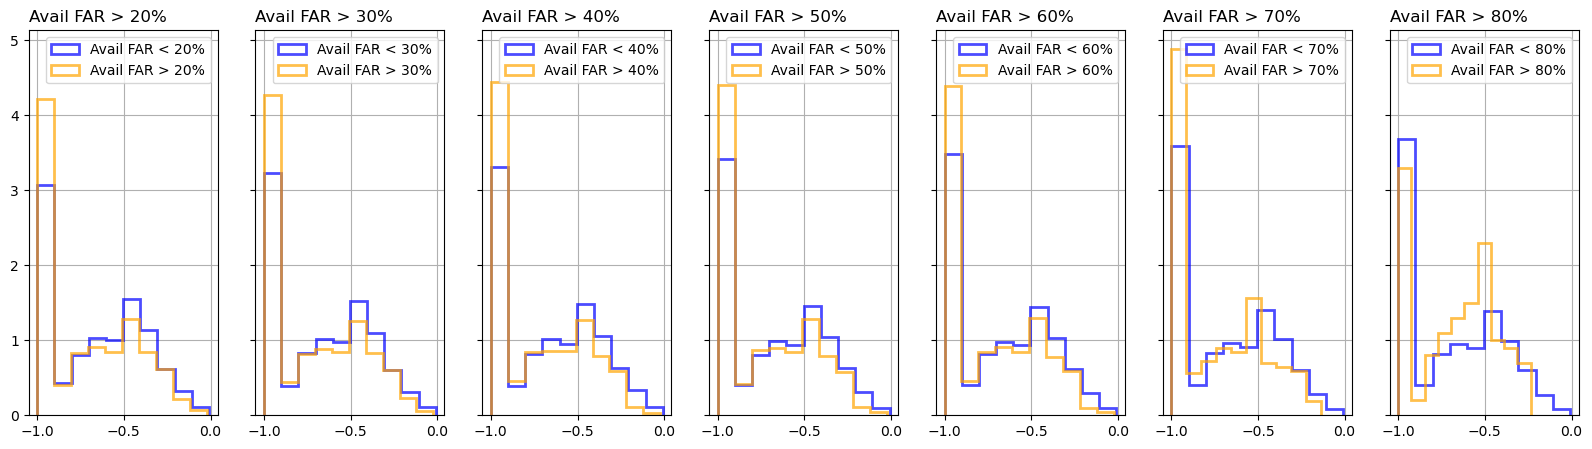

In [52]:
fig,axs = plt.subplots( ncols=len(cats) , figsize=(20,5) , sharey=True )

for i,c in enumerate(cats):
    t = geo_dfj[ geo_dfj['2022uc'] - geo_dfj['2007uc'] < 0 ].copy()

    t[ f'availfar_perc_morethan_{c*100:.0f}'] = np.where( t['availfar_perc_07'] >= c, True, False )
    t = t[ (t['change_uc'] > t['change_uc'].quantile(0.1)) & (t['change_uc'] < t['change_uc'].quantile(0.99)) ]
    t['change_uc_perc'] = t['change_uc'] / t['2007uc']

    ax = axs[i]
    
    t1 = t[ t[f'availfar_perc_morethan_{c*100:.0f}']==False]
    t2 = t[ t[f'availfar_perc_morethan_{c*100:.0f}']==True]

    t1['change_uc_perc'].hist(ax=ax, color='blue', density=True, alpha=0.7, histtype='step', lw=2)
    t2['change_uc_perc'].hist(ax=ax, color='orange', density=True, alpha=0.7, histtype='step', lw=2 )

    ax.set_title( f"Avail FAR > {c*100:.0f}%" , loc='left' )
    ax.legend( [f'Avail FAR < {c*100:.0f}%',f'Avail FAR > {c*100:.0f}%'] )

<Axes: xlabel='availfar_perc_07', ylabel='change_uc_cat'>

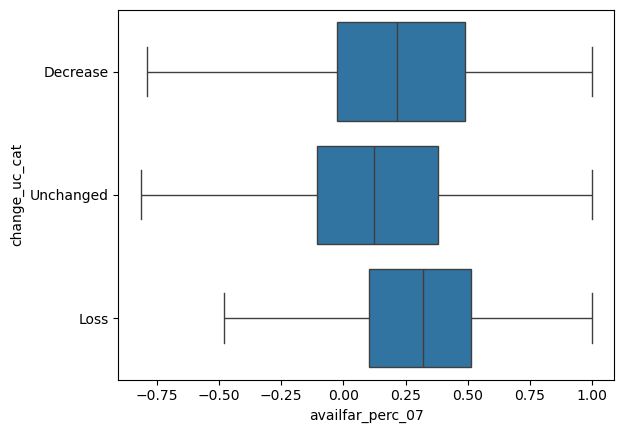

In [53]:
sns.boxplot( data=geo_dfj, x='availfar_perc_07', y='change_uc_cat', showfliers=False )

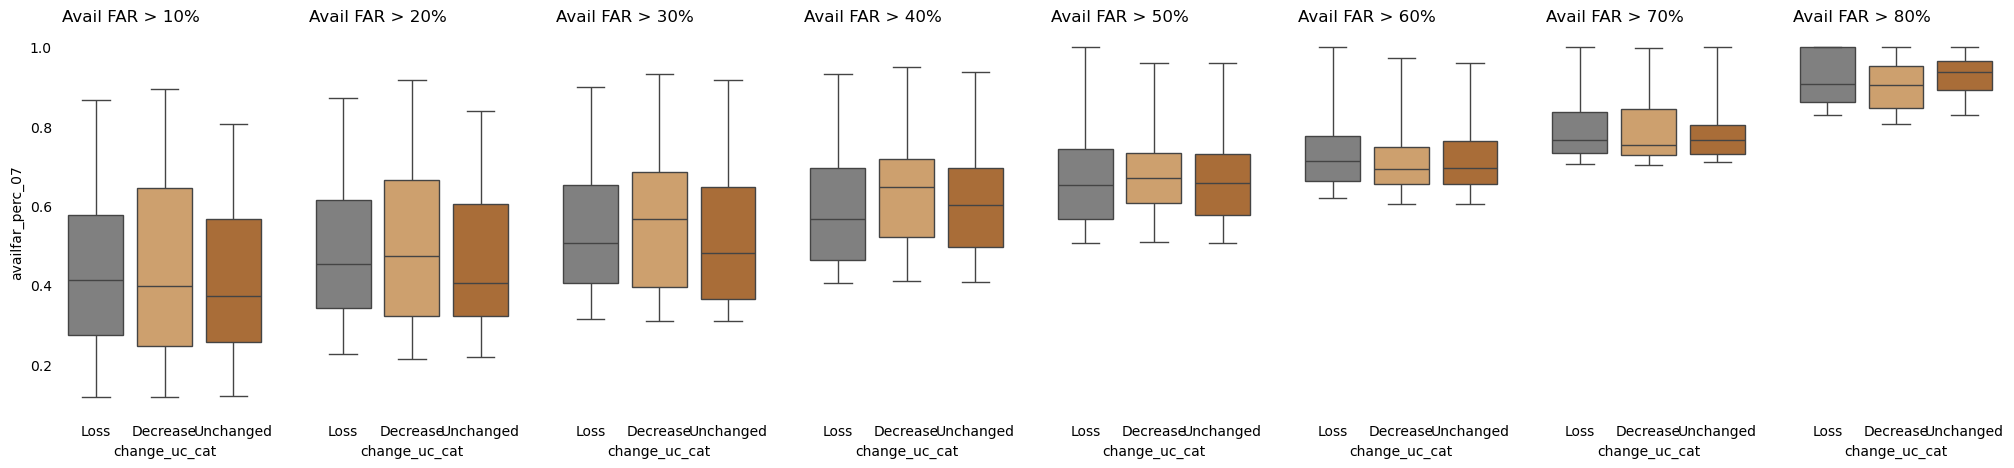

In [54]:
# Make a box plot version, comparing uncganed vs decrease
cats = np.arange(0.1,0.9,0.1)
fig,axs = plt.subplots( ncols=len(cats) , figsize=(25,5) , sharey=True )

colors = ['grey', '#dda15e', '#bc6c25']

for i,c in enumerate( cats ):
    t = geo_dfj.copy()

    t[ f'availfar_perc_morethan_{c*100:.0f}'] = np.where( t['availfar_perc_07'] >= c, True, False )
    # t = t[ (t['change_uc'] > t['change_uc'].quantile(0.1)) & (t['change_uc'] < t['change_uc'].quantile(0.99)) ]

    ax = axs[i]

    sns.boxplot(
        data = t[t[ f'availfar_perc_morethan_{c*100:.0f}'] == True ],
        x = 'change_uc_cat',
        hue = 'change_uc_cat',
        y = 'availfar_perc_07',
        ax=ax,
        whis = [2.5,97.5],
        showfliers=False,
        palette = colors,
        order = ['Loss','Decrease','Unchanged'],
        hue_order = ['Loss','Decrease','Unchanged']
    )



    ax.set_title( f"Avail FAR > {c*100:.0f}%" , loc='left' )
    ax.tick_params( axis='both', which='both', left=False, bottom=False )
    sns.despine( ax=ax , left=True , bottom=True )


Text(0.5, 1.0, 'Distribution of Change in Units for Decreases in Avail FAR')

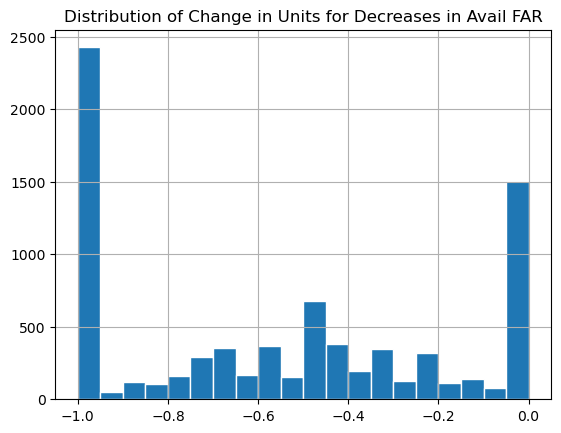

In [55]:
t = geo_dfj.copy()
t_decreases = t[ t['change_uc'] <= 0 ].copy()

t_decreases['change_uc_perc'] = t_decreases['change_uc'] / t_decreases['2007uc']
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] < 0, 'Decrease', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] ==-1 , 'Loss', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['2007uc'] - t_decreases['2022uc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )

t_decreases['change_uc_perc'].hist( ec='w', bins=20 )
plt.title( "Distribution of Change in Units for Decreases in Avail FAR" )

In [56]:
t = geo_dfj.copy()
t_decreases = t[ t['change_uc'] <= 0 ].copy()

t_decreases['change_uc_perc'] = t_decreases['change_uc'] / t_decreases['2007uc']
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] < 0, 'Decrease', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] ==-1 , 'Loss', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['2007uc'] - t_decreases['2022uc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )

change_perFAR = []
for c,i in enumerate(range(20,81,5)):
    
    col = f'availfar_perc_morethan_{i}'

    t_dec_filtered = t_decreases[ t_decreases[col] == True ].copy()
    decrease = t_dec_filtered[t_dec_filtered['change_uc_cat'] == 'Decrease']['change_uc'].sum()
    unchanged = t_dec_filtered[t_dec_filtered['change_uc_cat'] == 'Unchanged']['2007uc'].sum()
    loss = t_dec_filtered[t_dec_filtered['change_uc_cat'] == 'Loss']['change_uc'].sum()
    total = abs(decrease)+abs(unchanged)+abs(loss)

    change_perFAR.append( [ i ,decrease, unchanged, loss , abs(decrease+loss)/unchanged, decrease/total, unchanged/total, loss/total ] )

change_perFAR = pd.DataFrame( change_perFAR, columns=['Avail. FAR >', 'Decrease', "Unchanged", "Loss", "changed/unchaged", "Decrease%", "Unchanged %", "Loss %"] )
change_perFAR

,Avail. FAR >,Decrease,Unchanged,Loss,changed/unchaged,Decrease%,Unchanged %,Loss %
0,20,-15169,7165,-13187,3.957572,-0.427043,0.201712,-0.371245
1,25,-13751,6562,-11814,3.895916,-0.428020,0.204252,-0.367728
2,30,-12503,5935,-10243,3.832519,-0.435933,0.206931,-0.357135
3,35,-10760,4846,-8054,3.882377,-0.454776,0.204818,-0.340406
4,40,-9471,3904,-6827,4.174693,-0.468815,0.193248,-0.337937
5,45,-8170,3446,-6129,4.149449,-0.460411,0.194196,-0.345393
6,50,-7524,3167,-5513,4.116514,-0.464330,0.195446,-0.340225
7,55,-6865,2446,-4827,4.780049,-0.485571,0.173009,-0.341420
8,60,-6191,1951,-4105,5.277294,-0.505512,0.159304,-0.335184
9,65,-5263,1670,-3039,4.971257,-0.527778,0.167469,-0.304753


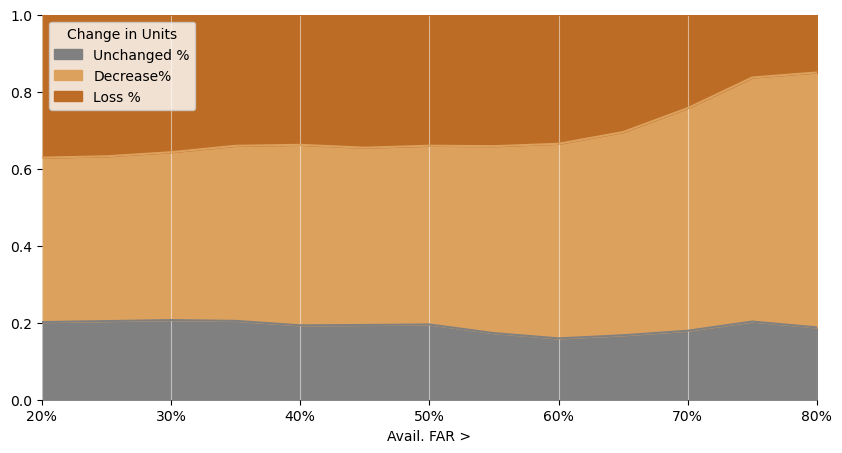

In [57]:
from matplotlib.colors import ListedColormap

fig,ax = plt.subplots( figsize=(10,5) )
change_perFAR[['Avail. FAR >', 'Unchanged %', 'Decrease%', 'Loss %']].abs()\
    .set_index('Avail. FAR >')\
    .plot(ax=ax, stacked=True, kind='area', figsize=(10,5), cmap=ListedColormap(['grey', '#dda15e', '#bc6c25']))

ax.set_ylim(0, 1)
ax.set_xlim( 20, 80 )
ax.legend( title='Change in Units' , loc='upper left')

sns.despine(ax=ax, left=True, bottom=True )
ax.grid( axis='x', ls='-', color='w', alpha=0.5 )

# x-axis is %
xticks = ax.get_xticks()
ax.set_xticks(xticks,  labels = [f'{int(i)}%' for i in xticks]);

### FAR Distribution

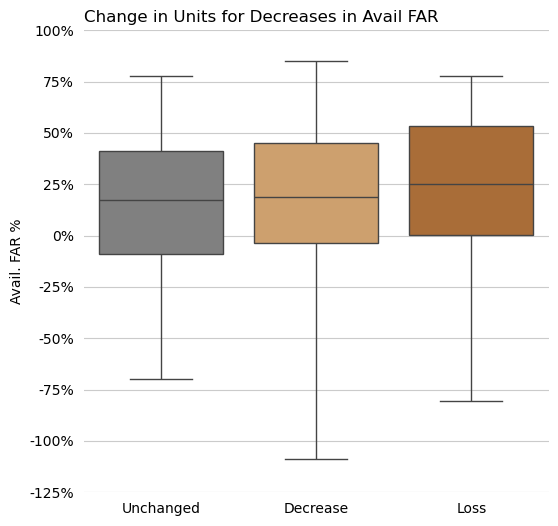

In [61]:
t = geo_dfj.copy()
t_decreases = t[ t['change_uc'] <= 0 ].copy()

t_decreases['change_uc_perc'] = t_decreases['change_uc'] / t_decreases['2007uc']
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] < 0, 'Decrease', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] ==-1 , 'Loss', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['2007uc'] - t_decreases['2022uc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )

colors = ['grey', '#dda15e', '#bc6c25']
plt.figure( figsize=(6,6) )
sns.boxplot(
    data = t_decreases,
    x = 'change_uc_cat',
    y = 'availfar_perc_07',
    showfliers=False,
    order = ['Unchanged','Decrease','Loss'],
    hue_order = ['Unchanged','Decrease','Loss'],
    hue =  'change_uc_cat',
    legend=False,
    palette=colors,
    # set to 1,99
    whis = [2.5,97.5]
)
plt.ylabel( "Avail. FAR %" )
plt.xlabel( "" )
plt.title( "Change in Units for Decreases in Avail FAR" , loc='left' )

sns.despine( left = True, bottom = True )
plt.tick_params( axis='both', left=False, bottom=False )
plt.grid( axis='y', ls='-', color='#333', alpha=0.25 )

# y-ticks are %
yticks = plt.gca().get_yticks()
plt.gca().set_yticks(yticks, labels = [f'{int(i*100)}%' for i in yticks]);

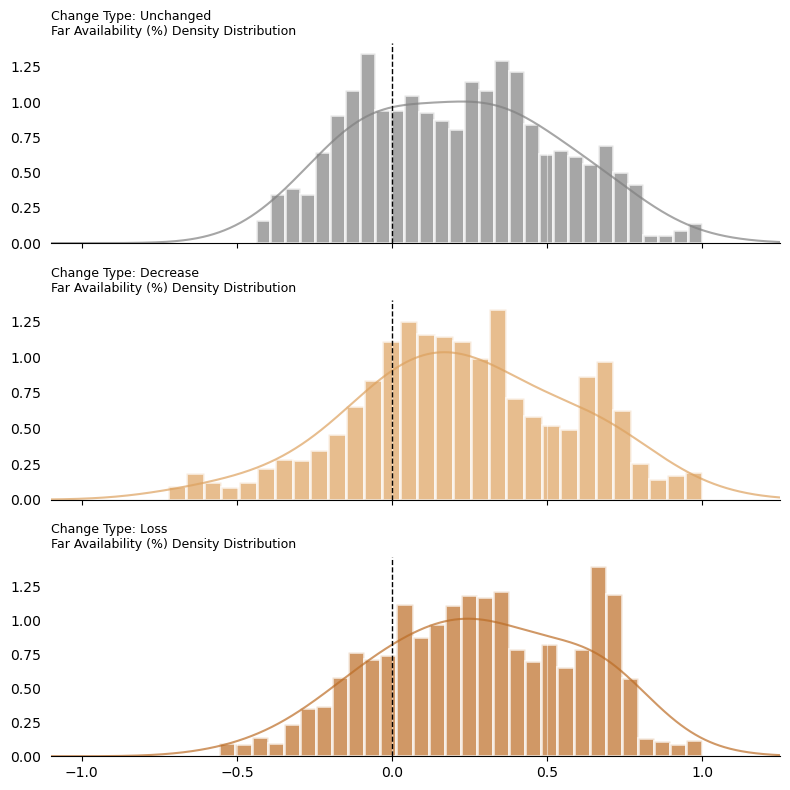

In [63]:
fig,axs = plt.subplots( nrows = 3, figsize=(8,8), sharex=True )

colors = ['grey', '#dda15e', '#bc6c25']
for i,cat in enumerate(['Unchanged','Decrease','Loss']):
    ax = axs[i]
    t_dec_filtered = t_decreases[ t_decreases['change_uc_cat'] == cat ].copy()
    t_dec_filtered = t_dec_filtered[ t_dec_filtered['availfar_perc_07'] > t_dec_filtered['availfar_perc_07'].quantile(0.05) ] 
    t_dec_filtered['availfar_perc_07'].plot.hist( ax=ax, bins=30, color=colors[i], alpha=0.7, density=True, histtype='bar', lw=2, ec='w' )
    t_dec_filtered['availfar_perc_07'].plot.kde( ax=ax, bw_method=0.5, color=colors[i], alpha=0.7 )

    ax.set_title( f"Change Type: {cat}\nFar Availability (%) Density Distribution" , loc='left', fontsize=9)
    ax.axvline( 0, color='k', ls='--', lw=1 )
    sns.despine(ax=ax, left=True )
    ax.grid( axis='x', ls='-', color='w', alpha=0.5 )
    ax.tick_params( axis='both', left=False )
    ax.set_xlim( -1.1,1.25 )
    ax.set_ylabel('')

fig.tight_layout()

C:\Users\cansu\AppData\Local\Temp\ipykernel_22492\1301052612.py:14: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


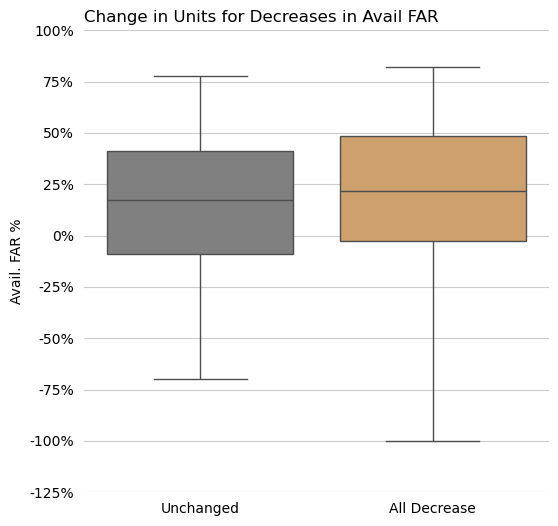

In [59]:
t = geo_dfj.copy()
t_decreases = t[ t['change_uc'] <= 0 ].copy()

t_decreases['change_uc_perc'] = t_decreases['change_uc'] / t_decreases['2007uc']
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] < 0, 'Decrease', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] ==-1 , 'Loss', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['2007uc'] - t_decreases['2022uc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )

t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_cat'] == 'Unchanged', 'Unchanged', 'All Decrease' )

colors = ['grey', '#dda15e', '#bc6c25']
plt.figure( figsize=(6,6) )
sns.boxplot(
    data = t_decreases,
    x = 'change_uc_cat',
    y = 'availfar_perc_07',
    showfliers=False,
    order = ['Unchanged','All Decrease'],
    hue_order = ['Unchanged','All Decrease'],
    hue =  'change_uc_cat',
    legend=False,
    palette=colors,
    # set to 1,99
    whis = [2.5,97.5]
)
plt.ylabel( "Avail. FAR %" )
plt.xlabel( "" )
plt.title( "Change in Units for Decreases in Avail FAR" , loc='left' )

sns.despine( left = True, bottom = True )
plt.tick_params( axis='both', left=False, bottom=False )
plt.grid( axis='y', ls='-', color='#333', alpha=0.25 )

# y-ticks are %
yticks = plt.gca().get_yticks()
plt.gca().set_yticks(yticks, labels = [f'{int(i*100)}%' for i in yticks]);

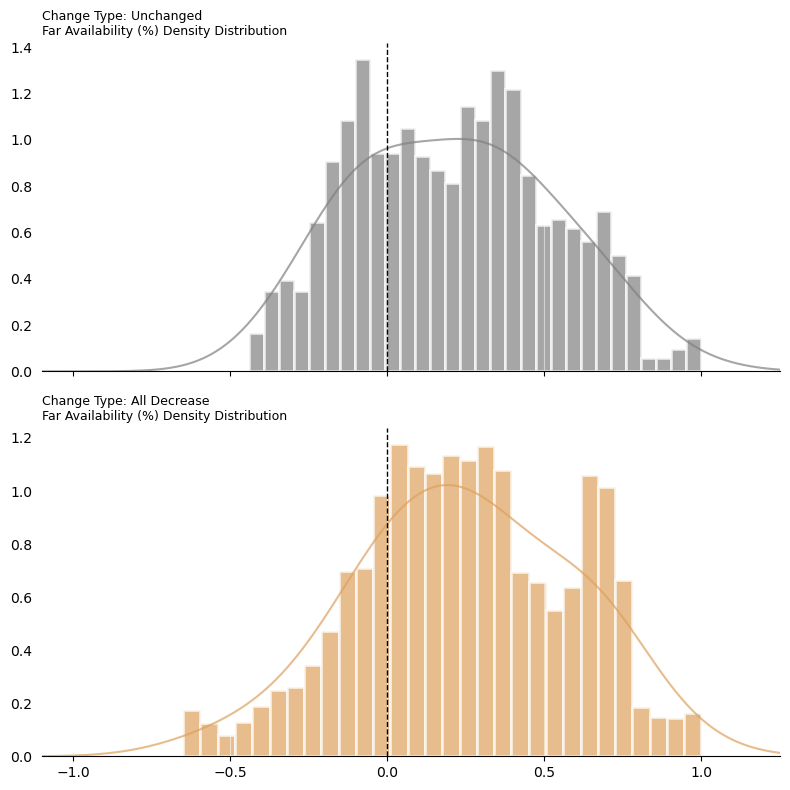

In [60]:
fig,axs = plt.subplots( nrows = 2, figsize=(8,8), sharex=True )

colors = ['grey', '#dda15e', '#bc6c25']
for i,cat in enumerate(['Unchanged','All Decrease']):
    ax = axs[i]
    t_dec_filtered = t_decreases[ t_decreases['change_uc_cat'] == cat ].copy()
    t_dec_filtered = t_dec_filtered[ t_dec_filtered['availfar_perc_07'] > t_dec_filtered['availfar_perc_07'].quantile(0.05) ] 
    t_dec_filtered['availfar_perc_07'].plot.hist( ax=ax, bins=30, color=colors[i], alpha=0.7, density=True, histtype='bar', lw=2, ec='w' )
    t_dec_filtered['availfar_perc_07'].plot.kde( ax=ax, bw_method=0.5, color=colors[i], alpha=0.7 )

    ax.set_title( f"Change Type: {cat}\nFar Availability (%) Density Distribution" , loc='left', fontsize=9)
    ax.axvline( 0, color='k', ls='--', lw=1 )
    sns.despine(ax=ax, left=True )
    ax.grid( axis='x', ls='-', color='w', alpha=0.5 )
    ax.tick_params( axis='both', left=False )
    ax.set_xlim( -1.1,1.25 )
    ax.set_ylabel('')

fig.tight_layout()

### Mapping Decrese vs Unchanged.

In [64]:
cds = r"D:\DATA\Community Districts.geojson"
cds = gpd.read_file( cds )
cds = cds[ cds['boro_cd'].str.startswith('1') ].copy()
cds.head()

,boro_cd,shape_area,shape_leng,geometry
18,164,38312378.4753,32721.0975431,"MULTIPOLYGON (((-73.94923 40.79687, -73.94942 ..."
25,109,41895775.3791,34959.2227132,"MULTIPOLYGON (((-73.94014 40.83037, -73.93963 ..."
27,108,55215029.0836,53753.3536852,"MULTIPOLYGON (((-73.94180 40.76905, -73.94257 ..."
29,105,43790039.865,35288.3342981,"MULTIPOLYGON (((-73.97301 40.76428, -73.97141 ..."
33,104,49310051.9094,67546.0454574,"MULTIPOLYGON (((-73.99394 40.77318, -73.99370 ..."


In [65]:
t = geo_dfj.copy()
t_decreases = t[ t['change_uc'] <= 0 ].copy()

t_decreases['change_uc_perc'] = t_decreases['change_uc'] / t_decreases['2007uc']
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] < 0, 'Decrease', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] ==-1 , 'Loss', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['2007uc'] - t_decreases['2022uc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )

cd_table = t_decreases.pivot_table( index='cd', columns='change_uc_cat', values=['change_uc','2007uc'], aggfunc='sum' )

cd_table = cd_table[
    [( '2007uc', 'Unchanged'),
    ('change_uc',  'Decrease'),
    ('change_uc',  'Loss')] ]

cd_table.columns = cd_table.columns.droplevel(0)
cd_table = cd_table.abs()
cd_table['Total'] = cd_table.sum(axis=1)

cd_table['Unchanged %'] = (cd_table['Unchanged'] / cd_table['Total']) * 100
cd_table['Decrease %'] = (cd_table['Decrease'] / cd_table['Total']) * 100
cd_table['Loss %'] = (cd_table['Loss'] / cd_table['Total']) * 100

cd_table

change_uc_cat,Unchanged,Decrease,Loss,Total,Unchanged %,Decrease %,Loss %
cd,,,,,,,
101,1802,886,1380,4068,44.296952,21.779744,33.923304
102,643,3483,2046,6172,10.418017,56.432275,33.149708
103,1583,1065,1516,4164,38.016330,25.576369,36.407301
104,5350,4918,4227,14495,36.909279,33.928941,29.161780
105,1714,2551,3333,7598,22.558568,33.574625,43.866807
106,1691,6323,3993,12007,14.083451,52.660948,33.255601
107,2129,6529,4108,12766,16.677111,51.143663,32.179226
108,1920,10529,6972,19421,9.886206,54.214510,35.899284
109,202,295,571,1068,18.913858,27.621723,53.464419


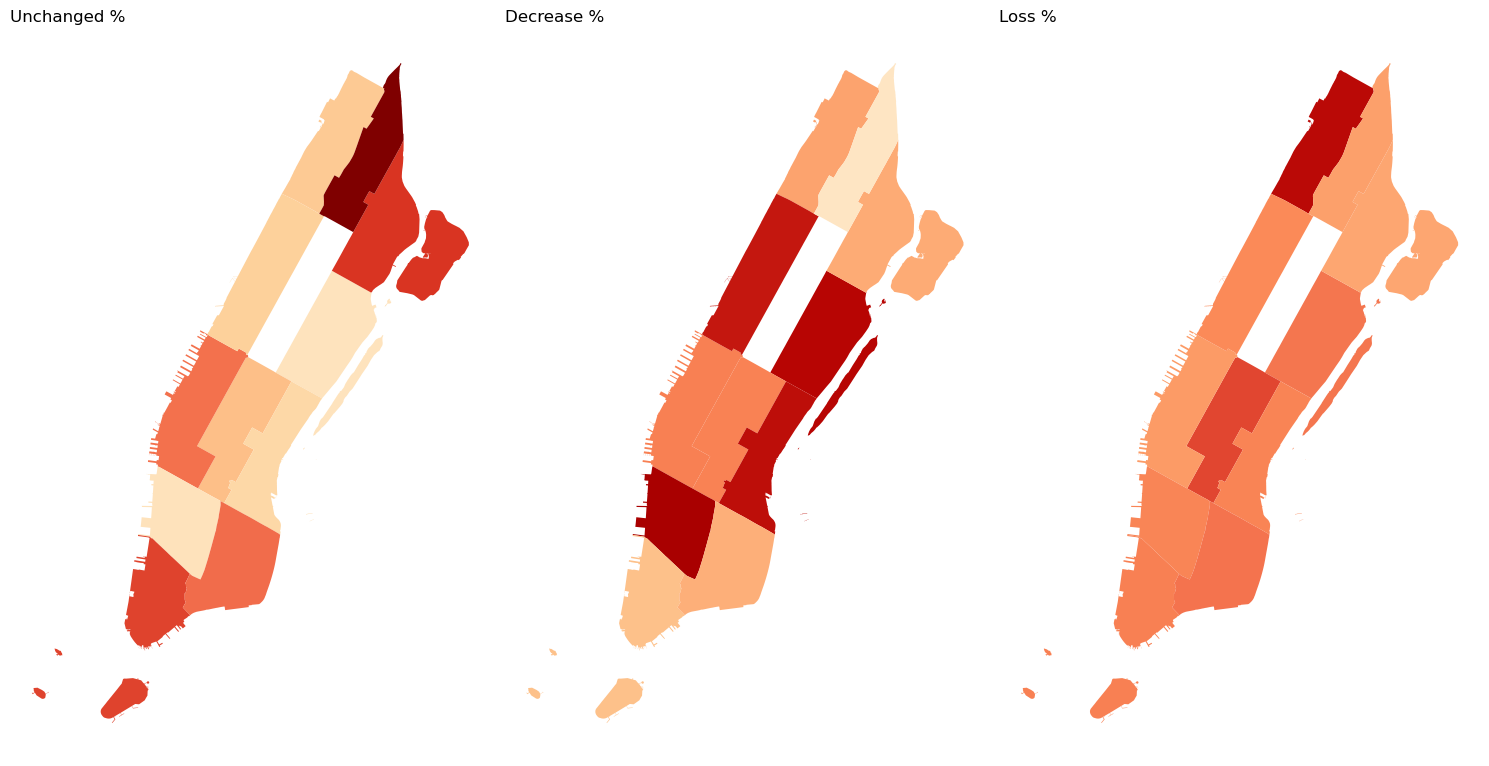

In [67]:
cds_mapped = cds.join( cd_table, on='boro_cd' ).dropna( axis=0, how='any' )

fig,axs = plt.subplots( ncols=3, figsize=(15,8) )

columns = ['Unchanged %', 'Decrease %', 'Loss %']

for i, col in enumerate(columns):
    ax= axs[i]
    cds_mapped.plot(column=col, ax=ax, legend=False, cmap="OrRd", 
                    legend_kwds={'label': '', 'shrink': 1 }, 
                    vmin=0, vmax=cds_mapped[columns].max().max())
    ax.set_title( columns[i], loc='left' )
    ax.axis('off')

fig.tight_layout( w_pad=1 )

## Zoning Districts

In [68]:
dist_list = r"C:\Users\cansu\Downloads\Distircts (2).xlsx"
dist_list = pd.read_excel( dist_list )
dist_list = dist_list.set_index('Residential Equivalent').stack().reset_index()
dist_list.columns = ['R', 'District', 'Equivalent']
dist_list = dist_list.drop( columns=['District'] )

dist_list.head()

,R,Equivalent
0,R6,C4-2
1,R6,C4-3
2,R6,C4-2A
3,R6,C4-3A
4,R6,C6-1A


In [69]:
t = geo_dfj.copy()
t_decreases = t[ t['change_uc'] <= 0 ].copy()

t_decreases['change_uc_perc'] = t_decreases['change_uc'] / t_decreases['2007uc']
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] < 0, 'Decrease', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['change_uc_perc'] ==-1 , 'Loss', t_decreases['change_uc_cat'] )
t_decreases['change_uc_cat'] = np.where( t_decreases['2007uc'] - t_decreases['2022uc'] == 0, 'Unchanged', t_decreases['change_uc_cat'] )

t_decreases['zonedist1_07A'] = t_decreases['zonedist1_07']
t_decreases['zonedist1_07A'] = t_decreases['zonedist1_07A'].str.strip()
t_decreases['zonedist1_07A'] = t_decreases['zonedist1_07A'].str.replace(r'^C6-2.*', 'C6-2', regex=True)
t_decreases['zonedist1_07A'] = t_decreases['zonedist1_07A'].str.replace(r'^C6-1.*', 'C6-1', regex=True)
t_decreases['zonedist1_07A'] = t_decreases['zonedist1_07A'].str.replace(r'^C6-2.*', 'C6-2', regex=True)
t_decreases['zonedist1_07A'] = t_decreases['zonedist1_07A'].str.replace(r'^C6-4.*', 'C6-4', regex=True)
t_decreases['zonedist1_07A'] = t_decreases['zonedist1_07A'].str.replace(r'^C5-1.*', 'C5-1', regex=True)
t_decreases['zonedist1_07A'] = t_decreases['zonedist1_07A'].str.replace(r'^C6-7.*', 'C6-7', regex=True)

t_zoning = t_decreases.join( dist_list.set_index('Equivalent'), on='zonedist1_07A' )

t_zoning['R'] = t_zoning['R'].fillna( t_zoning['zonedist1_07A'] ) 

t_zoning['R'] = t_zoning['R'].str.replace(r'^R7.*', 'R7', regex=True)
t_zoning['R'] = t_zoning['R'].str.replace(r'^R8.*', 'R8', regex=True)
t_zoning['R'] = t_zoning['R'].str.replace(r'^R9.*', 'R9', regex=True)
t_zoning['R'] = t_zoning['R'].str.replace(r'^R10.*', 'R10', regex=True)

t_zoning['R'].value_counts()

R
R8                     3105
R7                     2266
R10                    1879
R6                      752
R9                      288
Districts to Remove      50
M1-6                     38
M1-5M                    17
                         15
BATTERY PARK              7
M1-5                      7
M1-2                      4
M1-4                      4
NZS                       1
M1-1                      1
PARK                      1
Name: count, dtype: int64

In [70]:
r_zoning = t_zoning[(t_zoning['R'].str.startswith('R')) & (t_zoning['R'].notnull()) ].copy()
print( r_zoning.shape[0] , "<>", t_zoning.shape[0] )
r_zoning.head(3)

8290 <> 8455


,BBL_07,BBL_24,2007uc,2022uc,cd,ZD_Change,unitsres_07,resarea_07,bldgarea_07,builtfar_07,maxallwfar_07,landmark_07,histdist_07,zonedist1_07,availfar_07,availfar_perc_07,address_22,yearbuilt_22,unitsres_22,resarea_22,bldgarea_22,builtfar_22,residfar_22,histdist_22,maxallwfar_22,availfar_22,availfar_perc_22,change_uc,change_availfar,change_availfar_perc,xcoord,ycoord,change_uc_cat,geometry,BOROUGH,LP_NUMBER,CURRENT_,AREA_NAME,EXTENSION,STATUS_OF_,LAST_ACTIO,BOUNDARY_N,PUBLIC_HEA,OTHER_HEAR,Shape_area,Shape_len,DESDATE,CALDATE,DATE,EFFECTIVE_left,STATUS_left,ULURPNO_left,LUCATS_left,PROJECT_NA_left,Shape_Leng_left,Shape_Area_left,EFFECTIVE_right,STATUS_right,ULURPNO_right,LUCATS_right,PROJECT_NA_right,Shape_Leng_right,Shape_Area_right,index_right,EFFECTIVE,STATUS,ULURPNO,LUCATS,PROJECT_NA,Shape_Leng,Shape_Area,change_uc_perc,availfar_perc_morethan_20,availfar_perc_morethan_25,availfar_perc_morethan_30,availfar_perc_morethan_35,availfar_perc_morethan_40,availfar_perc_morethan_45,availfar_perc_morethan_50,availfar_perc_morethan_55,availfar_perc_morethan_60,availfar_perc_morethan_65,availfar_perc_morethan_70,availfar_perc_morethan_75,availfar_perc_morethan_80,zonedist1_07A,R
8,1017370025,1017370025,756,732,110,n,771.0,555954.0,555954.0,2.94,3.44,False,None,R7-2,0.50,0.145349,2300 5 AVENUE,1959.0,771.0,555954.0,555954.0,2.94,3.44,None,3.44,0.50,0.145349,-24,0.0,0.000000,1001916.0,236679.0,Decrease,POINT (1001916.000 236679.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.031746,False,False,False,False,False,False,False,False,False,False,False,False,False,R7-2,R7
13,1010150001,1010150001,651,650,105,n,652.0,207726.0,211466.0,12.03,12.00,False,None,C6-5,-0.03,-0.002500,680 8 AVENUE,1920.0,652.0,207726.0,211466.0,12.03,10.00,None,12.00,-0.03,-0.002500,-1,0.0,0.000000,987386.0,215392.0,Decrease,POINT (987386.000 215392.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001536,False,False,False,False,False,False,False,False,False,False,False,False,False,C6-5,R10
14,1000690018,1000690018,650,650,101,n,650.0,598366.0,627330.0,26.00,15.00,False,None,C5-5,-11.00,-0.733333,2 GOLD STREET,2003.0,650.0,582336.0,627300.0,26.00,10.00,None,12.00,-14.00,-1.166667,0,0.0,-0.433333,982328.0,197005.0,Unchanged,POINT (982328.000 197005.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,C5-5,R10


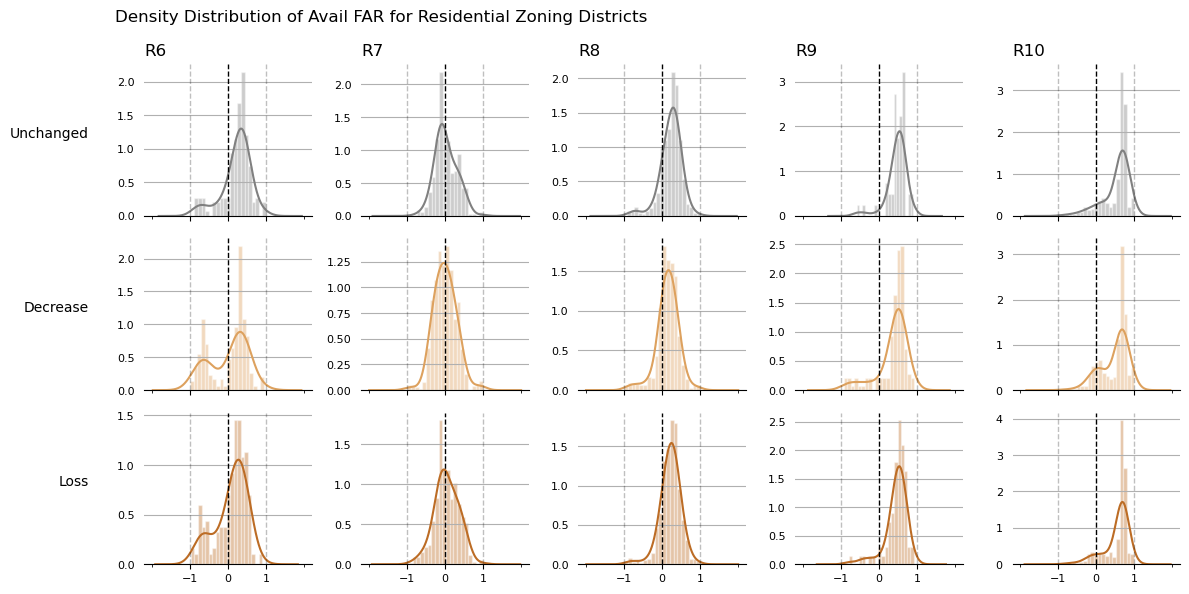

In [71]:
fig,axs = plt.subplots( nrows = 3, ncols=5, figsize=(12,6), sharex=True )
axs = axs.flatten()
colors = ['grey', '#dda15e', '#bc6c25']

count = 0
for n,cat in enumerate(['Unchanged','Decrease', 'Loss']):
    for i,zone in enumerate(['R6', 'R7', 'R8', 'R9', 'R10']):
    
        ax = axs[count]
        data = r_zoning[ (r_zoning['R'] == zone) & (r_zoning['change_uc_cat'] == cat) ].copy()
        data = data[data['availfar_perc_07'].between(-1,1)]

        if data.shape[0] > 10:
            
            data['availfar_perc_07'].plot.hist( ax=ax, bins=20, color=colors[n], alpha=0.4, density=True, histtype='bar', lw=1, ec='w' )
            data['availfar_perc_07'].plot.kde( ax=ax, bw_method=0.5, color=colors[n], alpha=1 )
            
            ax.axvline( 0, color='k', ls='--', lw=1 )
            ax.axvline( -1, color='k', ls='--', lw=1, alpha=0.25  )
            ax.axvline( 1, color='k', ls='--', lw=1, alpha=0.25 )

            ax.tick_params( axis='both', left=False , labelsize=8 )
            ax.set_xticks( [-1,0,1] )
            ax.grid(axis='y')

            if n == 0:
                ax.set_title( zone, loc='left' )


            if i!=0: 
                ax.set_ylabel('')
            else:
                ax.set_ylabel(cat, rotation=0, labelpad=20, ha='right')
            
            sns.despine( left=True )

        count = count + 1

fig.suptitle( "Density Distribution of Avail FAR for Residential Zoning Districts", fontsize=12, y=0.97, ha='left', va='center', x=0.1 )
fig.tight_layout()

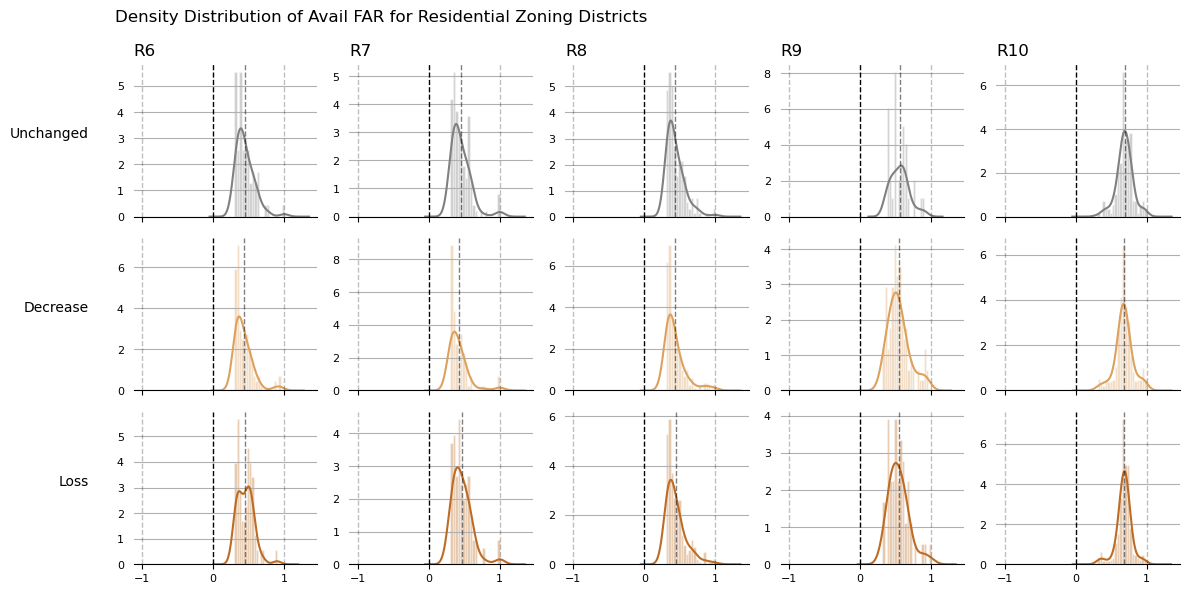

In [141]:
c = 0.3

fig,axs = plt.subplots( nrows = 3, ncols=5, figsize=(12,6), sharex=True )
axs = axs.flatten()
colors = ['grey', '#dda15e', '#bc6c25']


count = 0
for n,cat in enumerate(['Unchanged','Decrease', 'Loss']):
    for i,zone in enumerate(['R6', 'R7', 'R8', 'R9', 'R10']):
    
        ax = axs[count]
        r_zoning[ f'availfar_perc_morethan_{c*100:.0f}'] = np.where( r_zoning['availfar_perc_07'] >= c, True, False )

        data = r_zoning[ (r_zoning['R'] == zone) & (r_zoning['change_uc_cat'] == cat) & (r_zoning[ f'availfar_perc_morethan_{c*100:.0f}'] == True) ].copy()
        data = data[data['availfar_perc_07'].between(-1,1)]

        if data.shape[0] > 10:
            
            data['availfar_perc_07'].plot.hist( ax=ax, bins=20, color=colors[n], alpha=0.4, density=True, histtype='bar', lw=1, ec='w' )
            data['availfar_perc_07'].plot.kde( ax=ax, bw_method=0.5, color=colors[n], alpha=1 )
            
            ax.axvline( 0, color='k', ls='--', lw=1 )
            ax.axvline( -1, color='k', ls='--', lw=1, alpha=0.25  )
            ax.axvline( 1, color='k', ls='--', lw=1, alpha=0.25 )

            ax.tick_params( axis='both', left=False , labelsize=8 )
            ax.set_xticks( [-1,0,1] )
            ax.grid(axis='y')
            ax.axvline( data['availfar_perc_07'].mean()  , color='k', ls='--', lw=1, alpha=0.5  ) 

            if n == 0:
                ax.set_title( zone, loc='left' )


            if i!=0: 
                ax.set_ylabel('')
            else:
                ax.set_ylabel(cat, rotation=0, labelpad=20, ha='right')
            
            sns.despine( left=True )

        count = count + 1

fig.suptitle( "Density Distribution of Avail FAR for Residential Zoning Districts", fontsize=12, y=0.97, ha='left', va='center', x=0.1 )
fig.tight_layout()

## Descriptive Stats

Text(0.0, 1.0, 'Total Rent Stabilized Units in Manhattan')

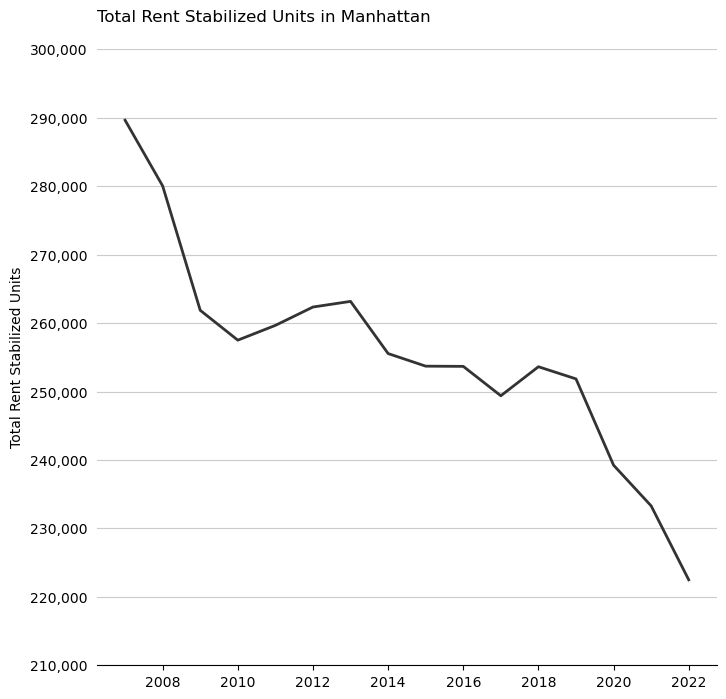

In [59]:
sums = df[['2007uc', '2008uc', '2009uc', '2010uc', '2011uc', '2012uc', '2013uc', '2014uc', '2015uc', '2016uc', '2017uc', '2018uc', '2019uc', '2020uc', '2021uc', '2022uc']].sum(axis=0).reset_index()
sums.columns = ['Year', 'Units']

sums['Year'] = sums['Year'].str.replace('uc','').astype(int)

fig,ax = plt.subplots( figsize=(8,8) )
sns.lineplot( data=sums, ax=ax, x='Year', y='Units', color = '#333', lw=2 )
sns.despine(ax=ax, left=True, bottom=False )
ax.tick_params( axis='both', left=False )
ax.grid( axis='y', ls='-', color='#333', alpha=0.25 )
ax.set_yticks( ax.get_yticks() , labels=[f'{i:,.0f}' for i in ax.get_yticks()] );
ax.set_ylabel( "Total Rent Stabilized Units" )
ax.set_xlabel( "" )
ax.set_title( "Total Rent Stabilized Units in Manhattan", loc='left' , pad=20 )

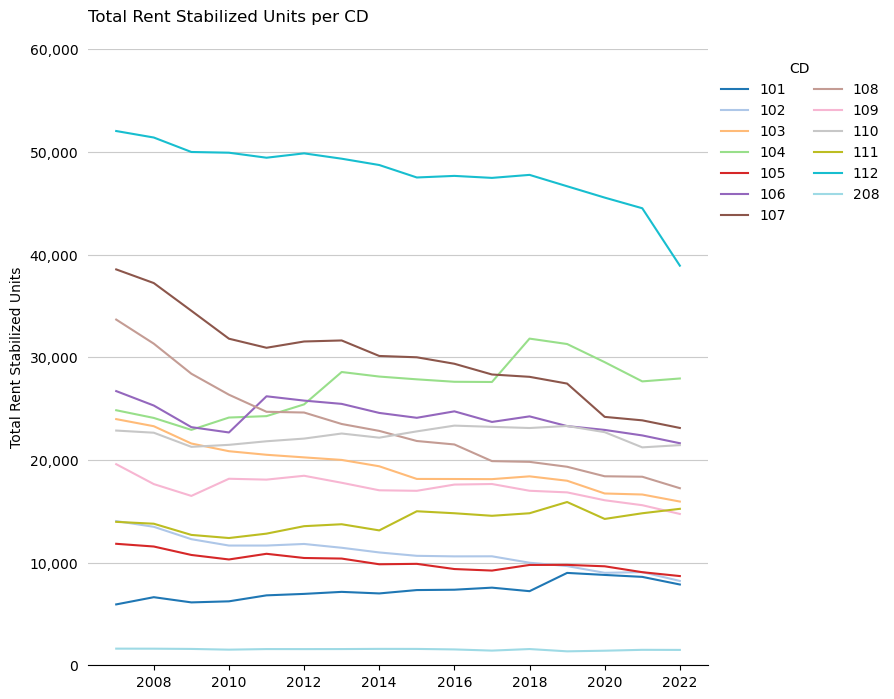

In [60]:
sums = df[['cd','2007uc', '2008uc', '2009uc', '2010uc', '2011uc', '2012uc', '2013uc', '2014uc', '2015uc', '2016uc', '2017uc', '2018uc', '2019uc', '2020uc', '2021uc', '2022uc']]

sums = sums.set_index('cd').stack().reset_index()
sums.columns = ['cd', 'Year', 'Units']

sums['Year'] = sums['Year'].str.replace('uc','').astype(int)

fig,ax = plt.subplots( figsize=(8,8) )
sums.pivot_table( index='cd', columns='Year', values='Units', aggfunc='sum' ).T.plot(ax=ax, kind='line', stacked=False , cmap='tab20' )

sns.despine(ax=ax, left=True, bottom=False )
ax.tick_params( axis='both', left=False )
ax.grid( axis='y', ls='-', color='#333', alpha=0.25 )
ax.set_yticks( ax.get_yticks() , labels=[f'{i:,.0f}' for i in ax.get_yticks()] );
ax.set_ylabel( "Total Rent Stabilized Units" )
ax.set_xlabel( "" )
ax.set_title( "Total Rent Stabilized Units per CD", loc='left' , pad=20 )
ax.set_ylim( 0, 60000 )
ax.legend( title='CD', ncol=2, bbox_to_anchor=(1,1), frameon=False )

In [61]:
df['ZoneDist07A'] = df['ZoneDist07'].str.strip()
df['ZoneDist07A'] = df['ZoneDist07A'].str.replace(r'^C6-2.*', 'C6-2', regex=True)
df['ZoneDist07A'] = df['ZoneDist07A'].str.replace(r'^C6-1.*', 'C6-1', regex=True)
df['ZoneDist07A'] = df['ZoneDist07A'].str.replace(r'^C6-2.*', 'C6-2', regex=True)
df['ZoneDist07A'] = df['ZoneDist07A'].str.replace(r'^C6-4.*', 'C6-4', regex=True)
df['ZoneDist07A'] = df['ZoneDist07A'].str.replace(r'^C5-1.*', 'C5-1', regex=True)
df['ZoneDist07A'] = df['ZoneDist07A'].str.replace(r'^C6-7.*', 'C6-7', regex=True)

alldata = df.join( dist_list.set_index('Equivalent'), on='ZoneDist07A' )
alldata['R'] = alldata['R'].fillna( alldata['ZoneDist07A'] )

alldata['ZoneDist24'].unique()

array(['R7-2', 'C6-4', 'C2-8', 'C4-6', 'C6-3', 'C6-3X', 'C6-5', 'C5-5',
       'C4-7', 'C6-4M', 'R10', 'C6-9', 'C1-7', 'C1-9', 'C6-4.5', 'C4-6A',
       'R9', 'C5-2', 'C6-4X', 'C5-3', 'R8B', 'C6-6', 'C2-7', 'R8A',
       'C5-2.5', 'C6-4A', 'BPC', 'C2-8A', 'C6-2', 'R7-1', 'C1-8X', 'R8',
       'C6-3A', 'C6-5.5', 'R10A', 'C1-7A', 'C4-4A', 'R7A', 'C6-2A', 'R8X',
       'C6-1', 'C4-4D', 'R9A', 'C5-1', 'C4-5', 'C6-2M', 'C1-8A', 'C4-5A',
       'C1-9A', 'C1-6A', 'R7B', 'R6A', 'R6', 'R5', 'C2-7A', 'C1-6',
       'PARK', 'C4-4', 'R7D', 'C8-3', 'R9X', 'C6-2G', 'C6-6.5', 'C5-P',
       'C6-1G', 'C2-6', 'C2-6A', 'C4-5D', 'C5-1A', 'C4-5X', 'R7X', 'C8-4',
       'R10H', 'C1-8', 'C6-7T', 'C6-7', 'R9-1'], dtype=object)

In [62]:
gr = timeline.groupby('R').agg({
    '2007uc': 'sum',
    '2008uc': 'sum',
    '2009uc': 'sum',
    '2010uc': 'sum',
    '2011uc': 'sum',
    '2012uc': 'sum',
    '2013uc': 'sum',
    '2014uc': 'sum',
    '2015uc': 'sum',
    '2016uc': 'sum',
    '2017uc': 'sum',
    '2018uc': 'sum',
    '2019uc': 'sum',
    '2020uc': 'sum',
    '2021uc': 'sum',
    '2022uc': 'sum'
})


gr = gr.T
gr.index = [int(i.split("uc")[0]) for i in gr.index]

fig, axs = plt.subplots( figsize=(10,5) , ncols = 2, sharex = True)
ax = axs[0]
gr.plot( ax=ax )
ax.set_title( "Change in Units by Residential Zoning Districts", loc='left' )
ax.legend( title='Zoning District' , frameon=False )
sns.despine(ax=ax, left=True )
ax.tick_params( axis='both', left=False )
ax.grid( axis='y', ls='--', color='#333', alpha=0.5 )

yticks = ax.get_yticks()
ax.set_yticks( yticks, labels=[f'{i/1000:,.0f}K' for i in yticks] );

ax = axs[1]
gr['R10_percent_change'] = gr['R10'].pct_change() * 100
gr['R9_percent_change'] = gr['R9'].pct_change() * 100
gr['R8_percent_change'] = gr['R8'].pct_change() * 100
gr['R7_percent_change'] = gr['R7'].pct_change() * 100
gr['R6_percent_change'] = gr['R6'].pct_change() * 100

gr[['R6_percent_change','R7_percent_change','R8_percent_change','R9_percent_change','R10_percent_change']].plot( ax=ax )
ax.legend( title='Zoning District' , frameon=False )
sns.despine(ax=ax, left=True )
ax.tick_params( axis='both', left=False )
ax.grid( axis='y', ls='--', color='#333', alpha=0.5 )



NameError: name 'timeline' is not defined

### Total Change

In [89]:

gr07 = duckdb.sql(
    f"""
    SELECT 
        CD::STRING as CD,
        SUM(UnitsRes::INT) as UnitsRes_07,
        COUNT(BBL) as lot_count_07
    FROM read_csv( {files}, ignore_errors=True )
    GROUP BY CD
    """
    ).df()

gr07.head()

,CD,UnitsRes_07,lot_count_07
0,318,64469.0,35615
1,406,55096.0,10360
2,502,48365.0,34364
3,211,41321.0,12665
4,412,74145.0,41277


In [90]:
gr22 = duckdb.sql(
    f"""
    SELECT cd::STRING as cd, SUM(unitsres) as UnitsRes_22, COUNT(bbl) as lot_count_22
    FROM read_csv( "C:/Users/cansu/Downloads/nyc_pluto_22v1_arc_csv/pluto_22v1.csv" , ignore_errors=True  )
    GROUP BY cd
    """
    ).df()

gr22.head()


,cd,UnitsRes_22,lot_count_22
0,409,46462.0,20415
1,408,59976.0,19376
2,104,88195.0,3428
3,205,52462.0,3276
4,482,0.0,9


In [92]:
gr = df.groupby( 'cd' ).agg({'2007uc':'sum', '2022uc':'sum'}).reset_index()
gr['cd'] = gr['cd'].astype(str)

gr = gr.join( gr07.set_index('CD'), on='cd', how='left' ).join( gr22.set_index('cd'), on='cd', how='left' )
gr

,cd,2007uc,2022uc,UnitsRes_07,lot_count_07,UnitsRes_22,lot_count_22
0,101,5929,7868,34898.0,1557,44013.0,1457
1,102,14043,8215,61289.0,4824,60496.0,4701
2,103,23977,15947,79365.0,4407,83705.0,4245
3,104,24841,27934,81514.0,3631,88195.0,3428
4,105,11833,8690,42386.0,3246,44526.0,2975
5,106,26706,21628,101266.0,2925,106045.0,2798
6,107,38559,23117,128465.0,4520,129181.0,4424
7,108,33672,17247,160605.0,5719,151152.0,5504
8,109,19587,14739,46039.0,2527,45269.0,2458
9,110,22863,21443,64990.0,4616,61269.0,4330


<Axes: ylabel='cd'>

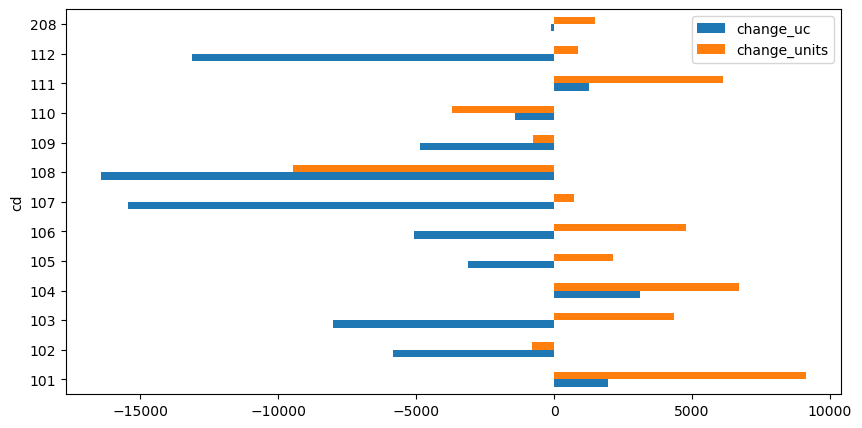

In [95]:
gr['change_uc'] = gr['2022uc'] - gr['2007uc']
gr['change_units'] = gr['UnitsRes_22'] - gr['UnitsRes_07']

gr[['cd','change_uc','change_units']].set_index('cd').plot( kind='barh', figsize=(10,5) )